In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as con
import sys
import os

sys.path.append('..')
import BOPackage

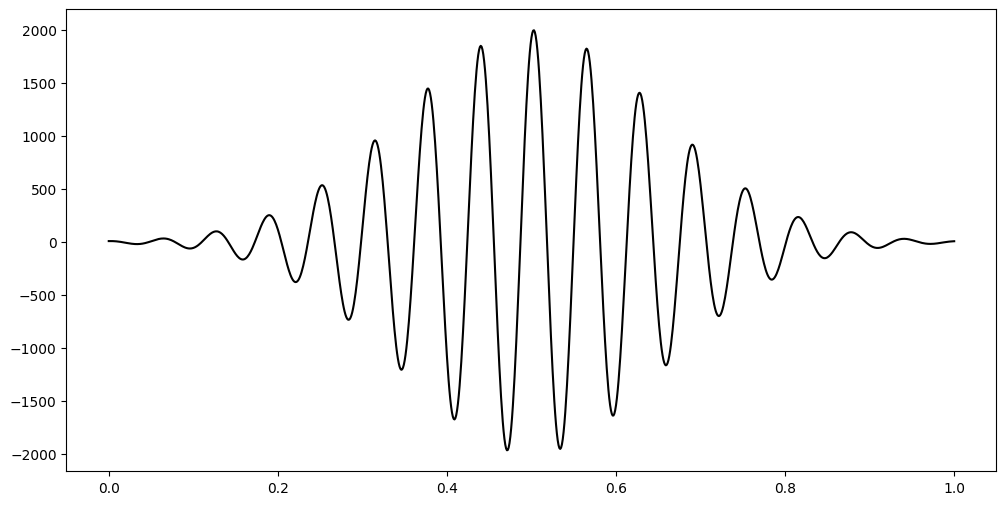

In [20]:
"""
Define the objective function.
"""

def ObjectiveFunction(x):
    x_centre = 0.5
    FWHM = 0.3
    width = FWHM / (2 * np.log(2))

    spatial_intensity =  np.exp(- ((x - x_centre) / width)**2)

    return 2000 * np.cos(100 * x) * spatial_intensity

X = np.linspace(0, 1, 1001, endpoint=True)

plt.figure(figsize=(12, 6))

plt.plot(X, ObjectiveFunction(X), color='k')

In [21]:
def PriorMeanFunction(X):
    return - np.zeros(len(X)).reshape(len(X), 1)

In [22]:
"""
Configure the optimiser.
"""
PriorMean = PriorMeanFunction
Kernel = BOPackage.RBF_Kernel_CPU
length_scale = 0.0055

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 2
min_kappa = 0.5

bounds = np.array([[0, 1]])
acquisition_samples = 10
random_seed = 27

log_path = '/work4/clf/david/Bayesian/Outputs/BO_Test_log_1'

# Create the object
bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                  KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  acquisition_samples=acquisition_samples,
                  #log_path=log_path,
                  random_seed=random_seed)

In [23]:
"""
Get first random batch and update the optimiser.
"""

raw_X = bo.GetRandomXBatch(batch_size=4)
raw_y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_y)

bo.X_data, bo.y_data

(array([[0.42572141],
        [0.81458374],
        [0.73539729],
        [0.8680032 ]]),
 array([[ 284.34724326],
        [ 235.71406822],
        [-173.81482427],
        [  43.87156213]]))

<Figure size 1200x600 with 0 Axes>

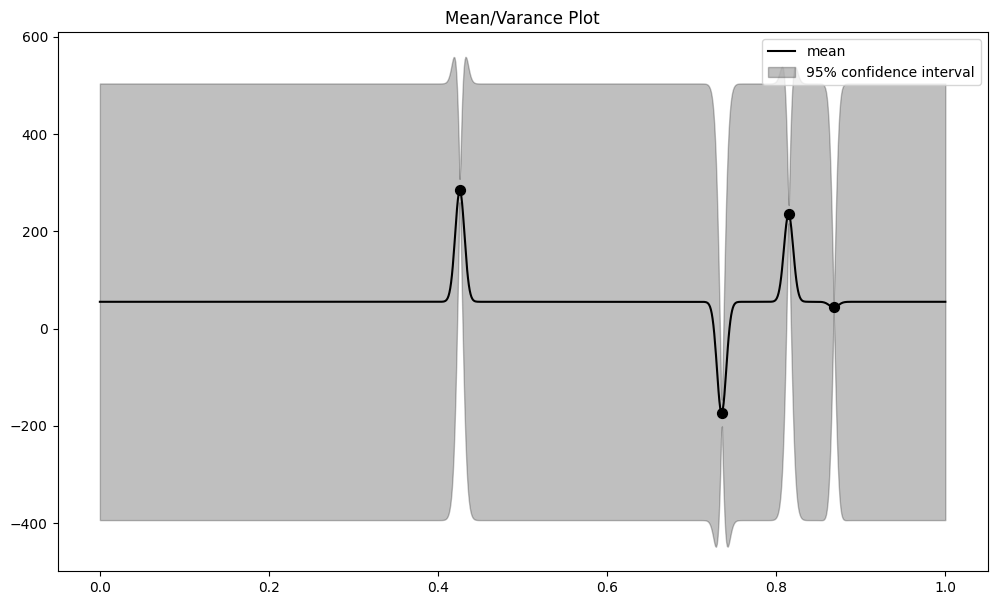

In [24]:
"""
Take a look at the mean and variance of the function now we have some data

NB: The y-axis is normalised such that the data points lie between -1 and 1, with the best point correspoinding to 1 
(i.e. if the problem is a minimisation problem, the samllest valued datapoint will be 1 and the largest valued datapoint will be -1)
"""

BOPackage.SausagePlot(bo)

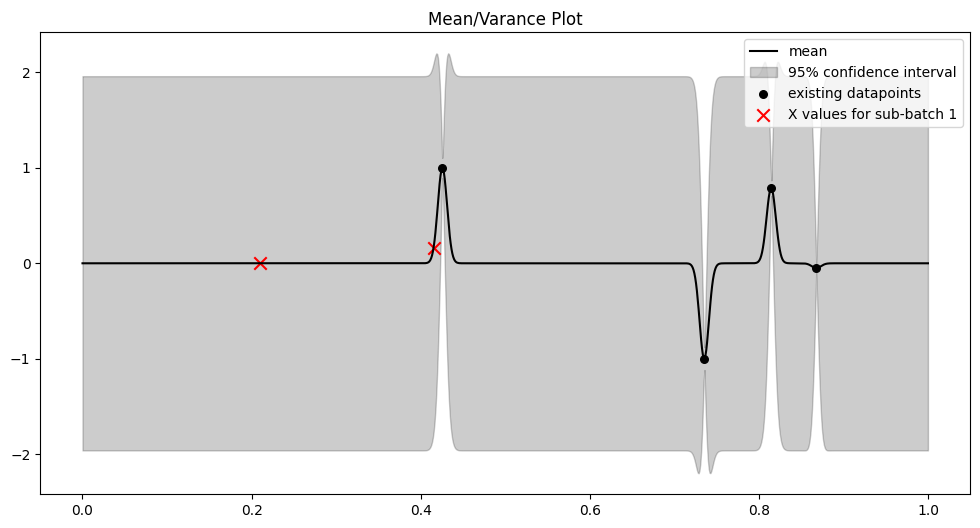

[[0.        ]
 [0.16403373]]


In [25]:
"""
Next, we'll determine the upcoming batch of four X values, divided into sub-batches of two.
We'll start by selecting the first two X values for the initial sub-batch:

(Note: This is a demonstration of how the code operates; the method of execution will be shown below.)
"""

batch_size = 4
sub_batch_size = 2
raw_X = np.empty((batch_size,len(bo.bounds)))

sub_batch_X = np.empty((sub_batch_size, len(bo.bounds)))
sub_batch_y = np.empty((sub_batch_size, 1))

K_inv = bo.InverseKernel()

for i in range(sub_batch_size):

    kappa = bo.CalculateKappa(sub_batch_size, i, max_kappa, min_kappa)

    sub_batch_X[i] = bo.GetNextX(kappa, K_inv=K_inv)

    raw_X[i] = sub_batch_X[i]

sub_batch_y = bo.PredictMeanVariance(sub_batch_X)[0]

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean', color='k')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color='k', alpha=0.2, label = '95% confidence interval')

normalized_y_data = 2 * (bo.y_data - np.min(bo.y_data)) / (np.max(bo.y_data) - np.min(bo.y_data)) - 1

if bo.minimise is True:
    normalized_y_data = -normalized_y_data

plt.scatter(bo.X_data, normalized_y_data, s=30, label='existing datapoints', color='k')

plt.scatter(sub_batch_X, sub_batch_y, color='red', marker='x', label='X values for sub-batch 1', s=80)

plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()

print(sub_batch_y)

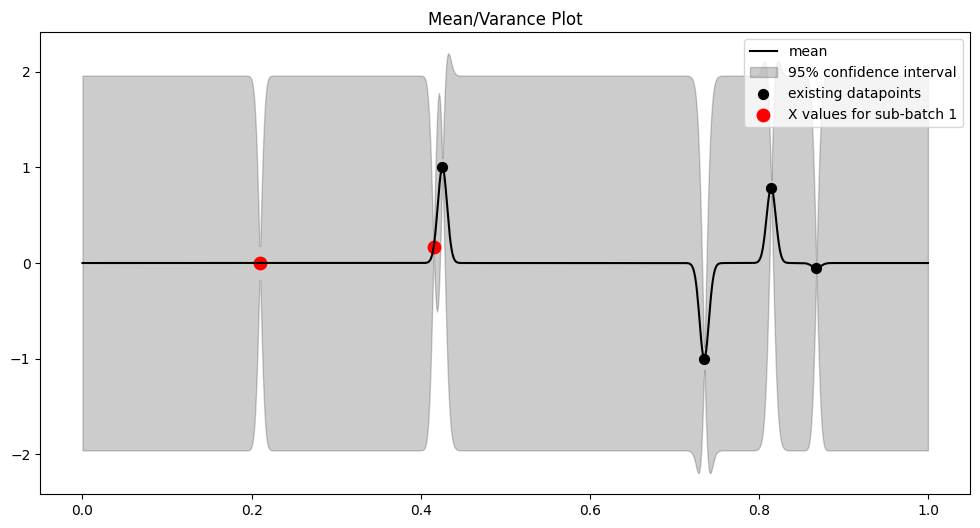

In [26]:
"""
Rather than calculating the actual y value for our new X values at this stage, we temporarily assign them the mean y value at these point.

Next, we recalculate the mean and variance with these new X values. Notice that the confidence interval drops to 0 at the new X values, even though the corresponding y values have not yet been calculated.
"""

bo.X_data = np.vstack([bo.X_data, sub_batch_X])

if bo.minimise is True:
    sub_batch_y = -sub_batch_y

unnormalised_sub_batch_y = (sub_batch_y + 1) / 2 * (np.max(bo.y_data) - np.min(bo.y_data)) + np.min(bo.y_data)

bo.y_data = np.vstack([bo.y_data, unnormalised_sub_batch_y])

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean', color='k')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'k', alpha=0.2, label = '95% confidence interval')

normalized_y_data = 2 * (bo.y_data - np.min(bo.y_data)) / (np.max(bo.y_data) - np.min(bo.y_data)) - 1

if bo.minimise is True:
    normalized_y_data = -normalized_y_data

plt.scatter(bo.X_data, normalized_y_data, s=50, label='existing datapoints', color='k')

plt.scatter(bo.X_data[-sub_batch_size:], normalized_y_data[-sub_batch_size:], s=80, color='red', label='X values for sub-batch 1')

plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()


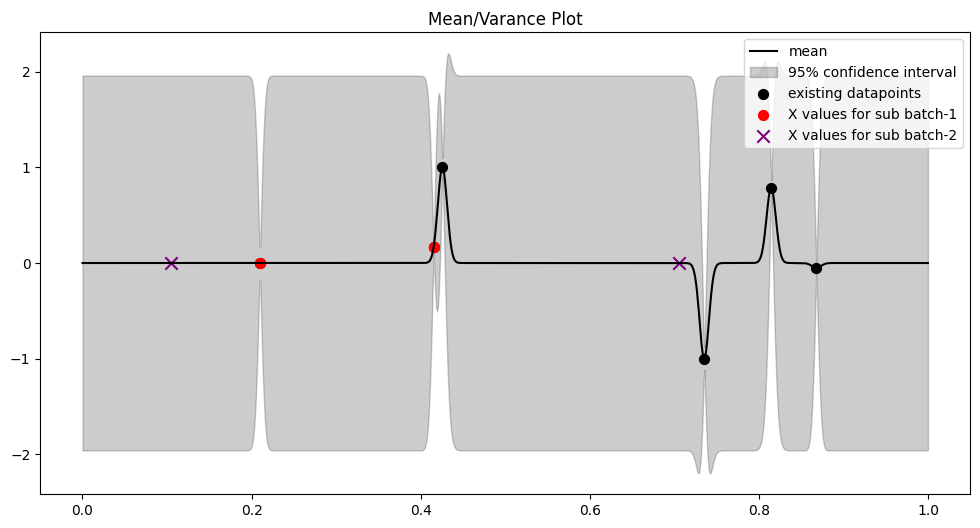

In [27]:
"""
Next, we repeat this process for sub batch two:
"""

sub_batch_X = np.empty((sub_batch_size, len(bo.bounds)))
sub_batch_y = np.empty((sub_batch_size, 1))

K_inv = bo.InverseKernel()

for i in range(sub_batch_size):

    kappa = bo.CalculateKappa(sub_batch_size, i, max_kappa, min_kappa)

    sub_batch_X[i] = bo.GetNextX(kappa, K_inv=K_inv)

    raw_X[i + 2] = sub_batch_X[i]

sub_batch_y = bo.PredictMeanVariance(sub_batch_X)[0]

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean', color='k')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'k', alpha=0.2, label = '95% confidence interval')

normalized_y_data = 2 * (bo.y_data - np.min(bo.y_data)) / (np.max(bo.y_data) - np.min(bo.y_data)) - 1

if bo.minimise is True:
    normalized_y_data = -normalized_y_data

plt.scatter(bo.X_data, normalized_y_data, s=50, label='existing datapoints', color='k')

plt.scatter(bo.X_data[-sub_batch_size:], normalized_y_data[-sub_batch_size:], s=50, color='red', label='X values for sub batch-1')

plt.scatter(sub_batch_X, sub_batch_y, color='purple', marker='x', label='X values for sub batch-2', s=80)


plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()

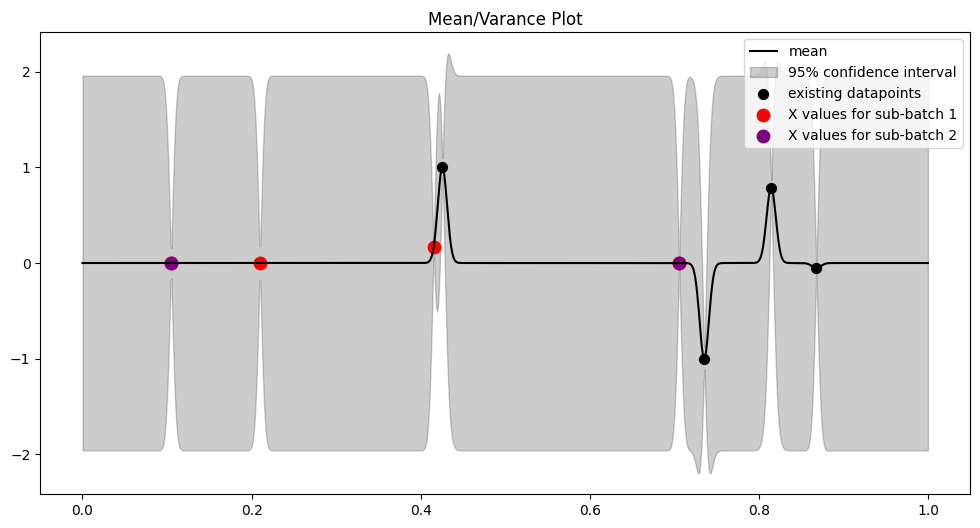

In [28]:
"""
Again, we recalculate the mean and variance for these new points and their corresponding means:
"""

bo.X_data = np.vstack([bo.X_data, sub_batch_X])

if bo.minimise is True:
    sub_batch_y = -sub_batch_y

unnormalised_sub_batch_y =  (sub_batch_y + 1) / 2 * (np.max(bo.y_data) - np.min(bo.y_data)) + np.min(bo.y_data)

bo.y_data = np.vstack([bo.y_data, unnormalised_sub_batch_y])

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean', color='k')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color='k', alpha=0.2, label = '95% confidence interval')

normalized_y_data = 2 * (bo.y_data - np.min(bo.y_data)) / (np.max(bo.y_data) - np.min(bo.y_data)) - 1

if bo.minimise is True:
    normalized_y_data = -normalized_y_data

plt.scatter(bo.X_data, normalized_y_data, s=50, label='existing datapoints', color='k')

plt.scatter(bo.X_data[-sub_batch_size*2:], normalized_y_data[-sub_batch_size*2:], s=80, color='red', label='X values for sub-batch 1')

plt.scatter(bo.X_data[-sub_batch_size:], normalized_y_data[-sub_batch_size:], s=80, color='purple', label='X values for sub-batch 2')


plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()


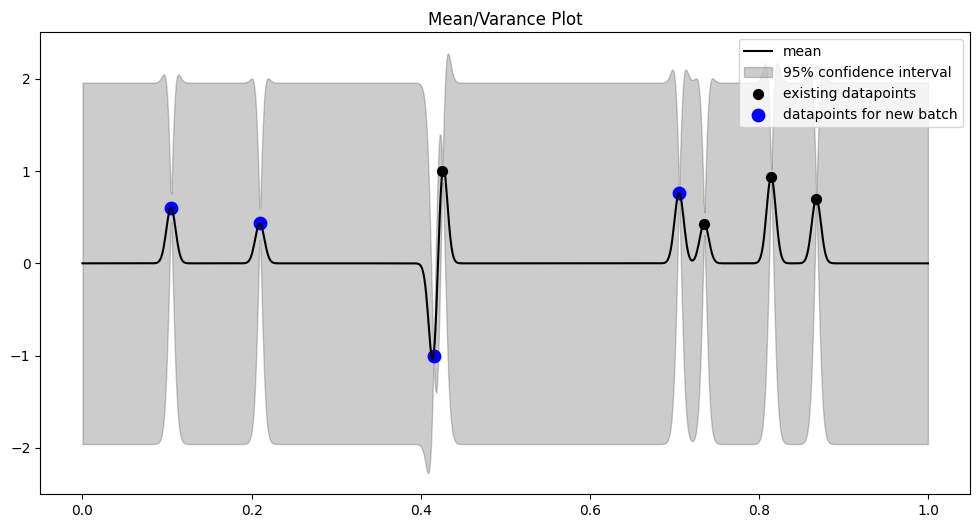

In [29]:
"""
These four points are now are X values for this batch. We pass these X values through our function to find the corresponding y values and find our new mean and variance.
"""

bo.X_data = bo.X_data[:-batch_size]
bo.y_data = bo.y_data[:-batch_size]

raw_y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_y)

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean', color='k')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color='k', alpha=0.2, label = '95% confidence interval')

normalized_y_data = 2 * (bo.y_data - np.min(bo.y_data)) / (np.max(bo.y_data) - np.min(bo.y_data)) - 1

if bo.minimise is True:
    normalized_y_data = -normalized_y_data

plt.scatter(bo.X_data, normalized_y_data, s=50, label='existing datapoints', color='k')

plt.scatter(bo.X_data[-sub_batch_size*2:], normalized_y_data[-sub_batch_size*2:], s=80, color='blue', label='datapoints for new batch')

plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()


In [30]:
"""
Here is the method for executing a batch of four with a sub-batch size of two:

First we collect a random sample as before:
"""

Kernel = BOPackage.RBF_Kernel_CPU
length_scale = 0.0055

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 2
min_kappa = 0.5

bounds = np.array([[0, 1]])
acquisition_samples = 10
random_seed = 27

log_path = '/work4/clf/david/Bayesian/Outputs/BO_Test_log_1'

# Create the object
bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                  KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  acquisition_samples=acquisition_samples,
                  #log_path=log_path,
                  random_seed=random_seed)

"""
Next, we collect a random sample:
"""

raw_X = bo.GetRandomXBatch(batch_size=4)
raw_y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_y)

"""
Now, we collect our batch of four with two sub-batches of two:
"""

raw_X = bo.GetNextXBatch(batch_size=4, sub_batch_size=2, max_kappa=max_kappa, min_kappa=min_kappa)
raw_y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_y)

<Figure size 1200x600 with 0 Axes>

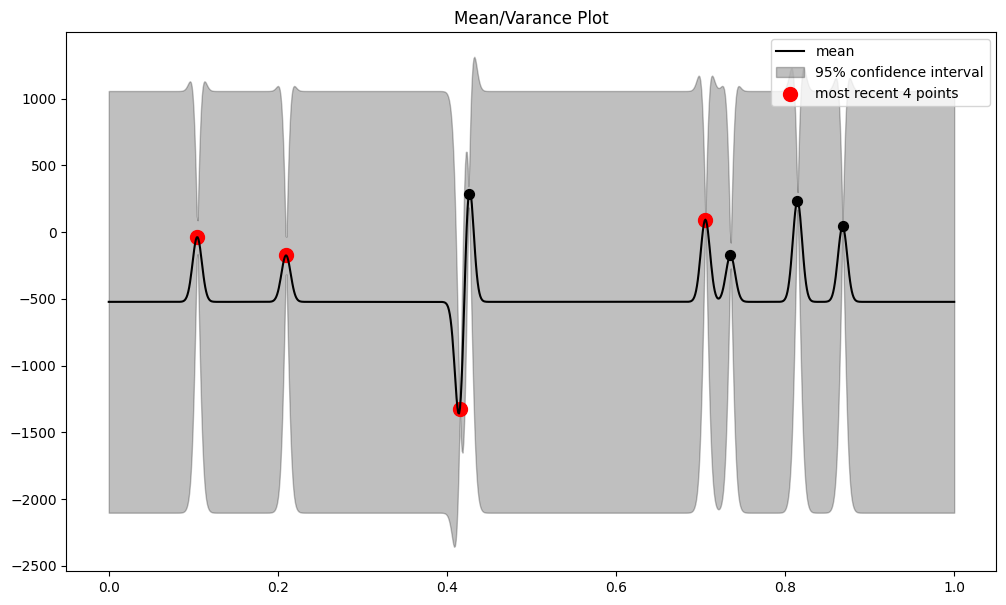

In [31]:
"""
If we plot our mean and variance, we expect to see exactly the same as above!
"""

BOPackage.SausagePlot(bo, highlight_recent=4, normalised=False)

In [32]:
"""
This is what would happen if sub-batching was not used. Notice three points cluster very closely. 
"""

Kernel = BOPackage.RBF_Kernel_CPU
length_scale = 0.04

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 2
min_kappa = 0.5

bounds = np.array([[0, 1]])
acquisition_samples = 10
random_seed = 27

log_path = '/work4/clf/david/Bayesian/Outputs/BO_Test_log_1'

# Create the object
bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                  KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  acquisition_samples=acquisition_samples,
                  #log_path=log_path,
                  random_seed=random_seed)

"""
Next, we collect a random sample:
"""

raw_X = bo.GetRandomXBatch(batch_size=4)
raw_y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_y)

"""
Now, we collect our batch of four with two sub-batches of two:
"""

raw_X = bo.GetNextXBatch(batch_size=4, max_kappa=max_kappa, min_kappa=min_kappa)
raw_y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_y)

<Figure size 1200x600 with 0 Axes>

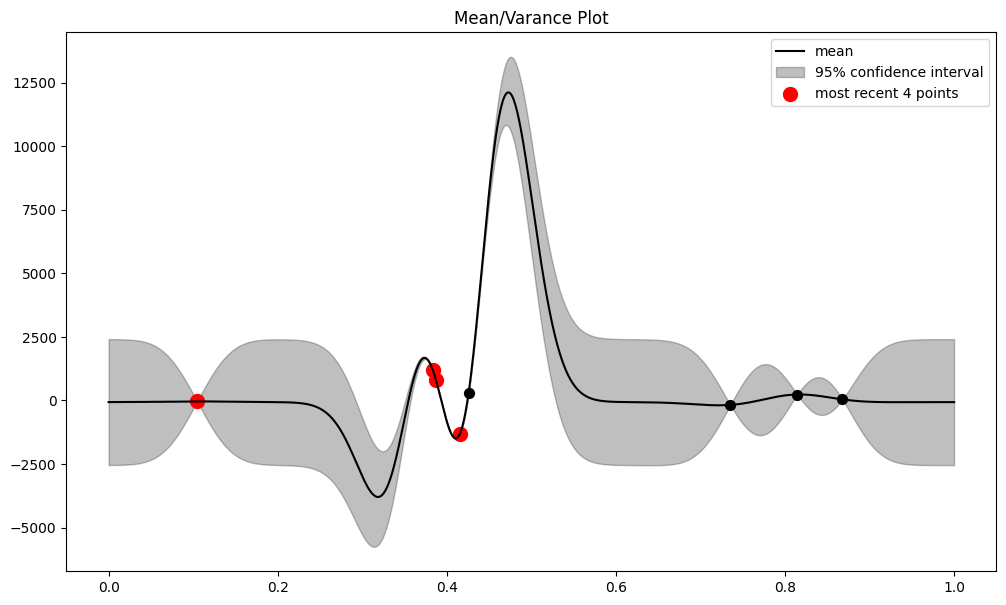

In [33]:
BOPackage.SausagePlot(bo, highlight_recent=4, normalised=False)